# Thrombin ligands for pharmacophore identification

We explore thrombing ligands that will be used to create ligand-based pharmacophore models

In [1]:
import openpharmacophore as oph

import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
import nglview as nv

from collections import defaultdict
from pprint import pprint
import os

from IPython.display import SVG
from tqdm.auto import tqdm

from read_sdf import read_sdf

## Load  and visualize ligands

We load the ligands from their respective smiles and draw their molecular structures

In [2]:
lig_df = pd.read_csv("ligands.csv")
lig_df

,Smiles,PDBID,LigID
0,[H]/N=C(\C1CCC(CC1)CNC(=O)[C@@H]2C=C(CN3N2C(=O...,1C4V,IH2
1,CN[C@H](Cc1ccccc1)C(=O)N2CCC[C@H]2C(=O)NCC3CCC...,1TOM,MIN
2,c1ccc(cc1)S(=O)(=O)CCN2C(=O)N3CC=C[C@H](N3C2=O...,1D6W,00R
3,c1ccc(cc1)S(=O)(=O)CCN2C(=O)N3CC=C[C@H](N3C2=O...,1D91,00P
4,[H]/N=C(/c1ccc(cc1)C[C@H](C(=O)N2CCCCC2)NC(=O)...,1DWD,MID
5,[H]/N=C(\c1ccc2c(c1)cc([nH]2)C(=O)N3CCC(CC3)Cc...,1D4P,BPP


In [3]:
def load_ligands():
    """ Load the ligands into a list of rdkit molecules."""
    ligands = []
    
    smiles = lig_df["Smiles"]
    pdb_ids = lig_df["PDBID"]
    
    for ii in range(len(smiles)):
        mol = Chem.MolFromSmiles(smiles[ii].encode("unicode_escape"))
        mol.SetProp("_Name", pdb_ids[ii])
        assert mol is not None
        ligands.append(mol)
    
    supp = Chem.SDMolSupplier("0ZI.sdf")
    mol = next(supp)
    mol.RemoveAllConformers()
    mol.SetProp("_Name", "1FPC")
    ligands.append(mol)

    print(f"Num ligands: {len(ligands)}")
    return ligands

Num ligands: 7


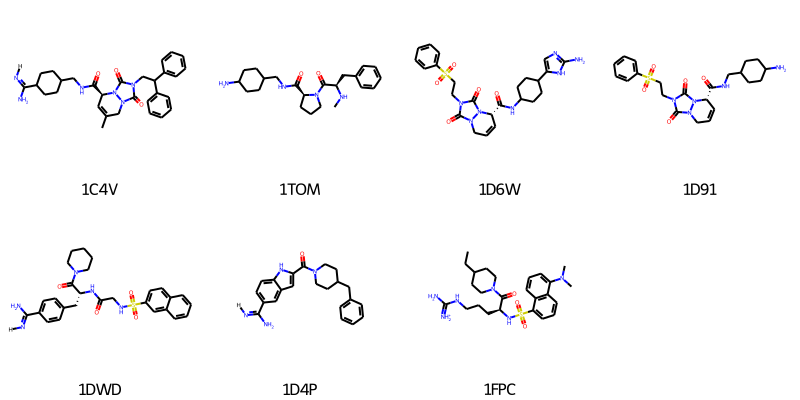

In [4]:
ligands = load_ligands()
legends = [l.GetProp("_Name") for l in ligands]
Draw.MolsToGridImage(ligands, legends=legends, molsPerRow=4)

## Preparing the ligands

We'll generate different conformers for each of the ligands and add hydrogens to them
as well.

In [5]:
pharmacophore = oph.LigandBasedPharmacophore()
pharmacophore.ligands = ligands

### Generating conformers

In [6]:
# Load conformers from file if present
conf_file = "./thrombin_ligands.sdf"
if os.path.isfile(conf_file):
    pharmacophore.ligands = read_sdf(conf_file)
else:
    pharmacophore.generate_conformers(n_confs=-1, ligands="all")
    
print([l.GetNumConformers() for l in pharmacophore.ligands])

[178, 171, 164, 153, 170, 42, 281]


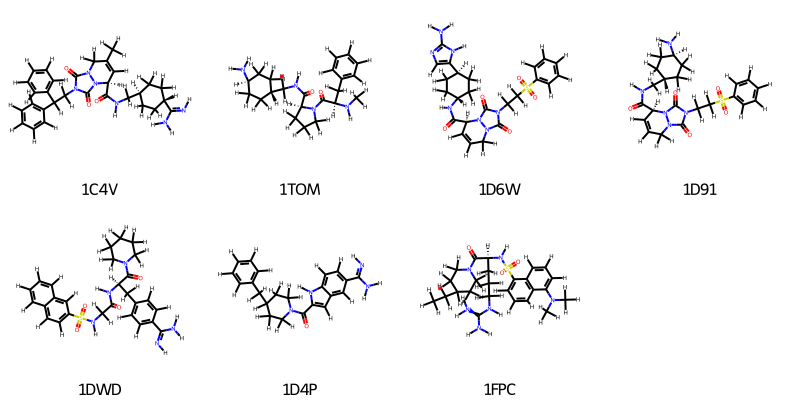

In [7]:
ligs_no_conf = [
    Chem.Mol(lig) for lig in pharmacophore.ligands
]
for lig in ligs_no_conf:
    lig.RemoveAllConformers()
Draw.MolsToGridImage(ligs_no_conf, legends=legends, molsPerRow=4)

In [8]:
# Save conformers to file
if not os.path.isfile(conf_file):
    writer = Chem.SDWriter("./thrombin_ligands.sdf")
    for lig in pharmacophore.ligands:
        for conf in range(lig.GetNumConformers()):
            writer.write(lig, confId=conf)
    writer.close()

## View 3D structures

In [9]:
lig_ind = 2
conf_ind = 2
nv.show_rdkit(pharmacophore.ligands[lig_ind], conf_ind=conf_ind)

NGLWidget()

## Chemical features

We find chemical features in the ligands and visualize them.

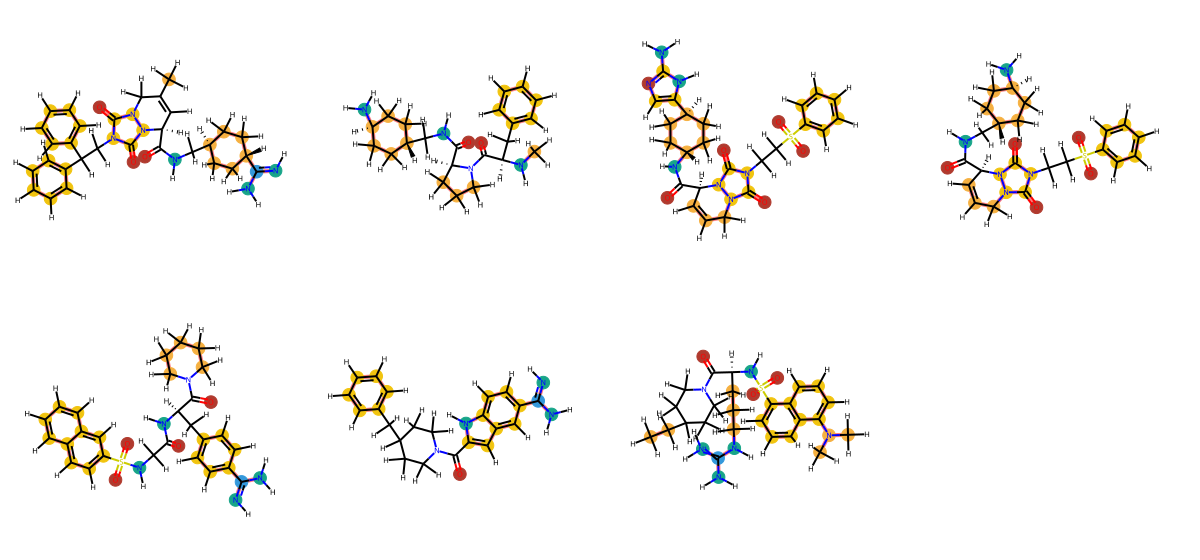

In [10]:
pharmacophore.find_chem_feats()
drawing = pharmacophore.draw((300, 280))
SVG(drawing.GetDrawingText())

## Extracting common pharmacophores

We extract common pharmacophores via recursive distance partitioning algorithm

### Finding 5-Point Pharmacophores

In [11]:
min_actives = len(pharmacophore.ligands) - 2
n_points = 5

In [12]:
pharmacophore.extract(
    n_points=n_points, min_actives=min_actives, max_pharmacophores=10
)
print(f"Found {len(pharmacophore)} common pharmacophores")

Found 10 common pharmacophores


In [13]:
for ph in pharmacophore:
    print([p.short_name for p in ph])

['A', 'A', 'A', 'H', 'R']
['A', 'A', 'D', 'D', 'H']
['A', 'A', 'D', 'D', 'H']
['A', 'A', 'D', 'D', 'H']
['A', 'A', 'D', 'D', 'H']
['A', 'A', 'D', 'D', 'H']
['A', 'A', 'D', 'D', 'R']
['A', 'A', 'D', 'D', 'R']
['A', 'A', 'D', 'D', 'R']
['A', 'A', 'D', 'D', 'R']


In [22]:
view = pharmacophore.show(0)
view

NGLWidget()

In [26]:
view.render_image()

Image(value=b'', width='99%')

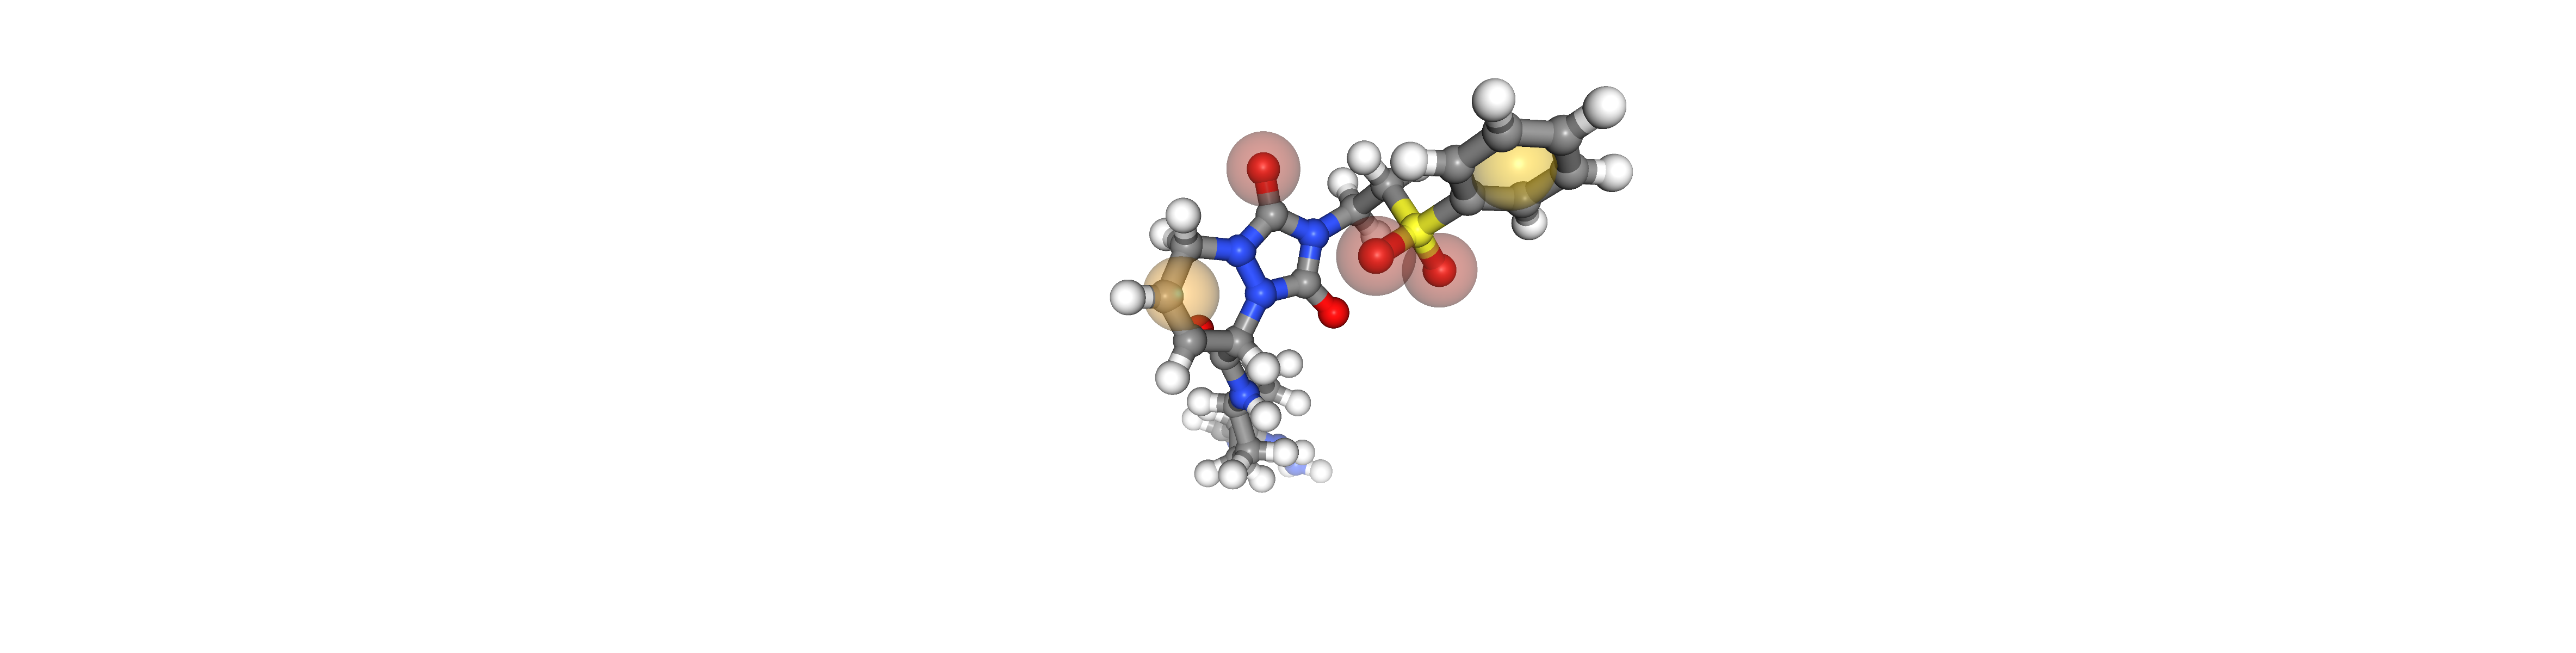

In [27]:
view._display_image()

### Finding 3-Point Pharmacophores

In [15]:
min_actives = len(pharmacophore.ligands)
n_points = 3

pharma_3 = oph.LigandBasedPharmacophore()
pharma_3.ligands = pharmacophore.ligands
pharma_3.find_chem_feats()
pharma_3.extract(
    n_points=n_points, min_actives=min_actives, max_pharmacophores=10
)

print(f"Found {len(pharma_3)} common pharmacophores")

Found 10 common pharmacophores


In [16]:
for ph in pharma_3:
    print([p.short_name for p in ph])

['A', 'D', 'D']
['A', 'D', 'D']
['A', 'D', 'D']
['A', 'D', 'D']
['A', 'D', 'D']
['A', 'D', 'D']
['A', 'D', 'D']
['A', 'D', 'D']
['A', 'D', 'D']
['A', 'D', 'D']


In [17]:
pharma_3.show(0)

NGLWidget()

### Finding 4-Point Pharmacophores

In [18]:
min_actives = len(pharmacophore.ligands)
n_points = 4

pharma_4 = oph.LigandBasedPharmacophore()
pharma_4.ligands = pharmacophore.ligands
pharma_4.find_chem_feats()
pharma_4.extract(
    n_points=n_points, min_actives=min_actives, max_pharmacophores=10
)

print(f"Found {len(pharma_4)} common pharmacophores")

Found 5 common pharmacophores


In [19]:
for ph in pharma_4:
    print([p.short_name for p in ph])

['A', 'D', 'D', 'R']
['A', 'D', 'D', 'R']
['A', 'D', 'D', 'R']
['A', 'D', 'D', 'R']
['A', 'D', 'D', 'R']


In [21]:
pharma_4.show(4)

NGLWidget()